In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))

for p in sys.path:
    print(p)

/home/coder/project/models/face_detection/yolov7-face-detection/tools
/root/.pyenv/versions/3.9.13/lib/python39.zip
/root/.pyenv/versions/3.9.13/lib/python3.9
/root/.pyenv/versions/3.9.13/lib/python3.9/lib-dynload

/root/.pyenv/versions/3.9.13/envs/torch/lib/python3.9/site-packages
/root/.local/lib/python3.9/site-packages
..


In [2]:
import yaml

with open("../data/hyp.scratch.tiny.yaml", errors="ignore") as f:
    hyp = yaml.safe_load(f)
hyp


{'lr0': 0.01,
 'lrf': 0.01,
 'momentum': 0.937,
 'weight_decay': 0.0005,
 'warmup_epochs': 3.0,
 'warmup_momentum': 0.8,
 'warmup_bias_lr': 0.1,
 'box': 0.05,
 'lmks': 0.1,
 'lmks_mask': 0.5,
 'cls': 0.5,
 'cls_pw': 1.0,
 'obj': 1.0,
 'obj_pw': 1.0,
 'iou_t': 0.2,
 'anchor_t': 4.0,
 'fl_gamma': 0.0,
 'hsv_h': 0.015,
 'hsv_s': 0.7,
 'hsv_v': 0.4,
 'degrees': 0.0,
 'translate': 0.1,
 'scale': 0.5,
 'shear': 0.0,
 'perspective': 0.0,
 'flipud': 0.0,
 'fliplr': 0.5,
 'mosaic': 1.0,
 'mixup': 0.05,
 'loss_ota': 1}

In [3]:
from utils.datasets import LoadImagesAndLabels


dataset = LoadImagesAndLabels(
    path="/home/coder/project/datasets/face_detections/widerface/train.txt",
    img_size=640,
    batch_size=2,
    augment=True,
    hyp=hyp,
    rect=False,
    image_weights=False,
    cache_images=True,
    single_cls=False,
    stride=32,
    pad=0,
    prefix="",
)

Scanning '/home/coder/project/datasets/face_detections/widerface/train.cache' images and labels... 12880 found, 0 missing, 0 empty, 4 corrupted: 100%|██████████| 12880/12880 [00:00<?, ?it/s]
Caching images (11.1GB): 100%|██████████| 12876/12876 [00:40<00:00, 317.65it/s]


## Utils function

In [4]:
import cv2
import matplotlib.pyplot as plt

def visualize_image(image):
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(image)
    plt.show()

In [5]:
import cv2
import matplotlib.pyplot as plt

BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White
LEFT_COLOR = (255, 0, 0)
CENTER_COLOR = (0, 255, 0)
RIGHT_COLOR = (0, 0, 255)


def visualize_bbox(
    img,
    bbox,
    landmark,
    landmark_mask,
    color=BOX_COLOR,
    thickness=2,
    radius=2,
    bbox_type="coco",
    landmark_normalized: bool = True,
):
    r"""Visualizes a single bounding box on the image
    Args:
        bbox: coco
    """

    if bbox_type == "coco":
        x_min, y_min, w, h = bbox
        x_min, x_max, y_min, y_max = (
            int(x_min),
            int(x_min + w),
            int(y_min),
            int(y_min + h),
        )
    elif bbox_type == "pascal_voc":
        x_min, y_min, x_max, y_max = bbox
    elif bbox_type == "albumentations":
        x_min, y_min, x_max, y_max = bbox
        x_min, y_min, x_max, y_max = (
            int(x_min * img.shape[1]),
            int(y_min * img.shape[0]),
            int(x_max * img.shape[1]),
            int(y_max * img.shape[0]),
        )
    elif bbox_type == "yolo":
        cx, cy, w, h = bbox
        x_min, y_min, x_max, y_max = cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2
        x_min, y_min, x_max, y_max = (
            int(x_min * img.shape[1]),
            int(y_min * img.shape[0]),
            int(x_max * img.shape[1]),
            int(y_max * img.shape[0]),
        )
    else:
        raise KeyError("bbox_type error")

    x_min, y_min, x_max, y_max = (
        int(round(x_min)),
        int(round(y_min)),
        int(round(x_max)),
        int(round(y_max)),
    )

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    if landmark is not None and landmark_mask > 0:
        img = cv2.circle(
            img,
            (int(landmark[0] * img.shape[1]), int(landmark[1] * img.shape[0]))
            if landmark_normalized
            else (int(landmark[0]), int(landmark[1])),
            radius=radius,
            color=LEFT_COLOR,
            thickness=-1,
        )
        img = cv2.circle(
            img,
            (int(landmark[2] * img.shape[1]), int(landmark[3] * img.shape[0]))
            if landmark_normalized
            else (int(landmark[2]), int(landmark[3])),
            radius=radius,
            color=RIGHT_COLOR,
            thickness=-1,
        )
        img = cv2.circle(
            img,
            (int(landmark[4] * img.shape[1]), int(landmark[5] * img.shape[0]))
            if landmark_normalized
            else (int(landmark[4]), int(landmark[5])),
            radius=radius,
            color=CENTER_COLOR,
            thickness=-1,
        )
        img = cv2.circle(
            img,
            (int(landmark[6] * img.shape[1]), int(landmark[7] * img.shape[0]))
            if landmark_normalized
            else (int(landmark[6]), int(landmark[7])),
            radius=radius,
            color=LEFT_COLOR,
            thickness=-1,
        )
        img = cv2.circle(
            img,
            (int(landmark[8] * img.shape[1]), int(landmark[9] * img.shape[0]))
            if landmark_normalized
            else (int(landmark[8]), int(landmark[9])),
            radius=radius,
            color=RIGHT_COLOR,
            thickness=-1,
        )

    return img


def visualize(
    image,
    bboxes,
    landmarks,
    landmarks_mask,
    bbox_type="coco",
    thickness=2,
    radius=2,
    landmark_normalized: bool = True,
):
    img = image.copy()
    for bbox, landmark, landmark_mask in zip(bboxes, landmarks, landmarks_mask):
        img = visualize_bbox(
            img,
            bbox,
            landmark,
            landmark_mask,
            bbox_type=bbox_type,
            thickness=thickness,
            radius=radius,
            landmark_normalized=landmark_normalized,
        )
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(img)
    plt.show()


# Test dataset

In [6]:
import random

index = random.randint(0, len(dataset.indices))

img, labels, paths, shape = dataset[index]
img.shape, labels.shape

(torch.Size([3, 640, 640]), torch.Size([161, 17]))

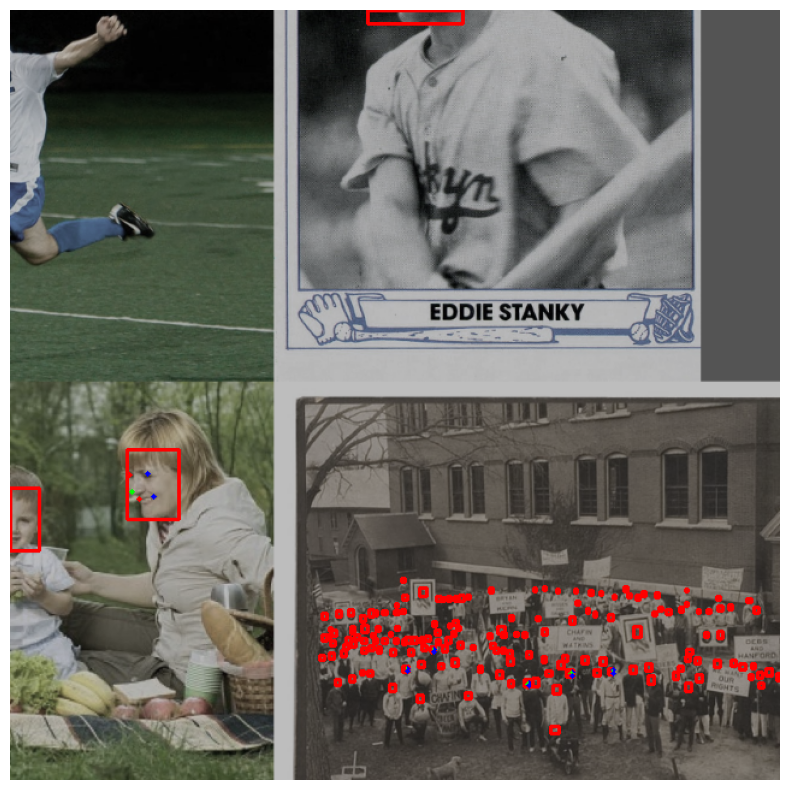

In [7]:
import numpy as np

visualize(
    np.clip(img.numpy(), 0, 255).astype(np.uint8).transpose(1, 2, 0),
    labels[:, 2:6].numpy(),
    labels[:, 6:16].numpy(),
    labels[:, 16].numpy(),
    "yolo",
    landmark_normalized=True,
)


# Test dataloader

In [8]:
img1, label1, path1, shape1 = dataset[random.randint(0, len(dataset.indices))]
img2, label2, path2, shape2 = dataset[random.randint(0, len(dataset.indices))]
img3, label3, path3, shape3 = dataset[random.randint(0, len(dataset.indices))]
img4, label4, path4, shape4 = dataset[random.randint(0, len(dataset.indices))]

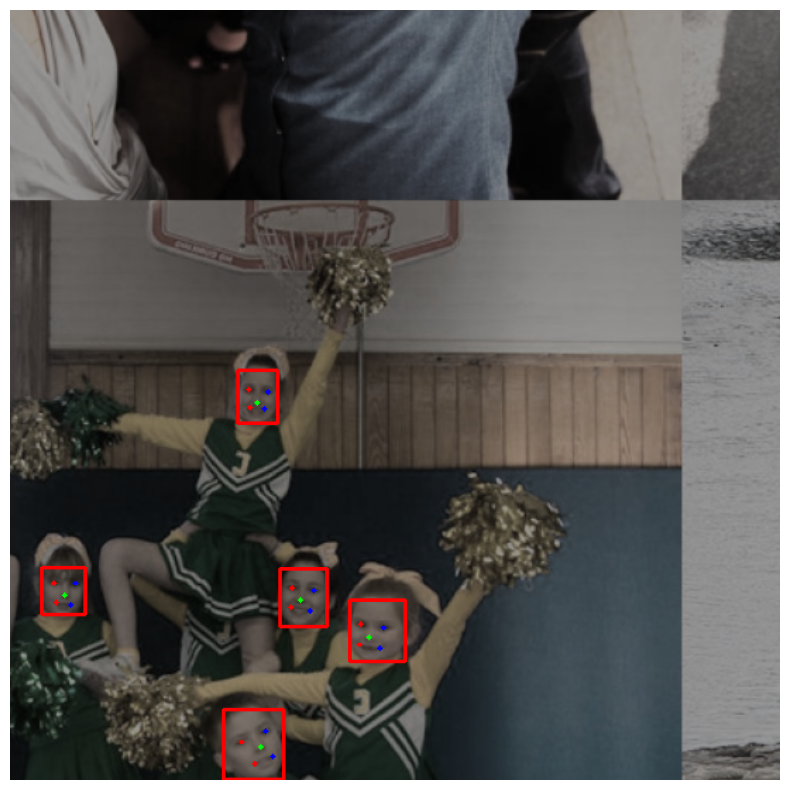

In [9]:
%matplotlib inline

import numpy as np

visualize(
    np.clip(img1.numpy(), 0, 255).astype(np.uint8).transpose(1, 2, 0),
    label1[:, 2:6].numpy(),
    label1[:, 6:16].numpy(),
    label1[:, 16].numpy(),
    "yolo",
    landmark_normalized=True,
)

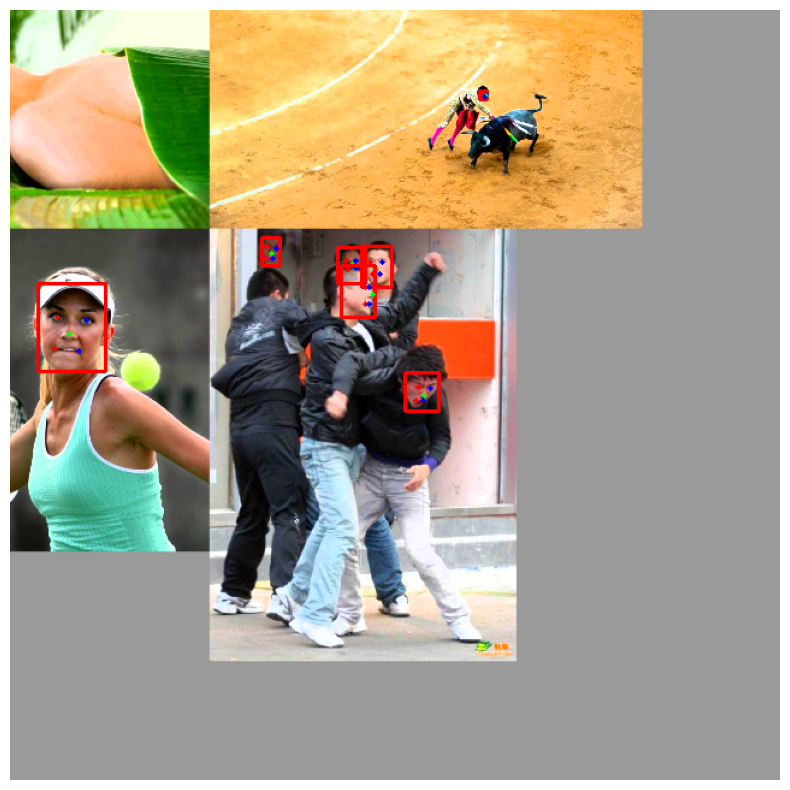

In [10]:
%matplotlib inline

import numpy as np

visualize(
    np.clip(img2.numpy(), 0, 255).astype(np.uint8).transpose(1, 2, 0),
    label2[:, 2:6].numpy(),
    label2[:, 6:16].numpy(),
    label2[:, 16].numpy(),
    "yolo",
    landmark_normalized=True,
)

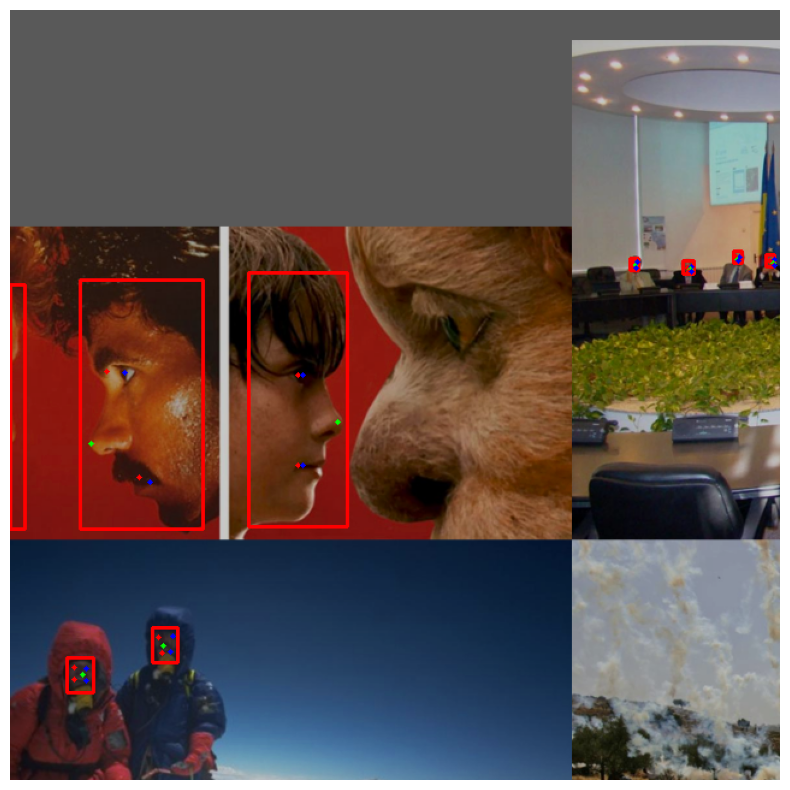

In [11]:
%matplotlib inline

import numpy as np

visualize(
    np.clip(img3.numpy(), 0, 255).astype(np.uint8).transpose(1, 2, 0),
    label3[:, 2:6].numpy(),
    label3[:, 6:16].numpy(),
    label3[:, 16].numpy(),
    "yolo",
    landmark_normalized=True,
)

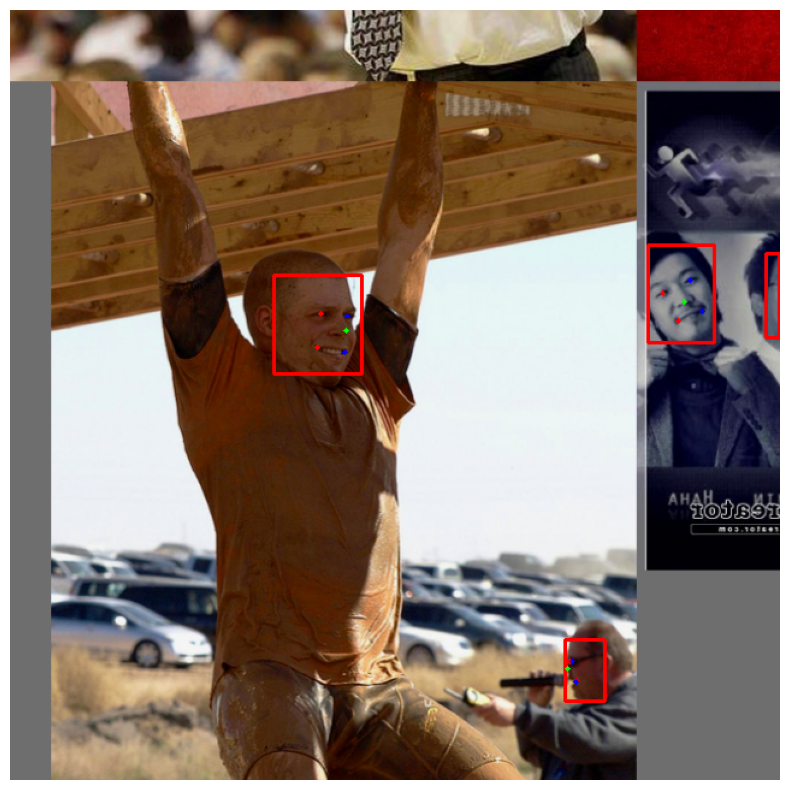

In [12]:
%matplotlib inline

import numpy as np

visualize(
    np.clip(img4.numpy(), 0, 255).astype(np.uint8).transpose(1, 2, 0),
    label4[:, 2:6].numpy(),
    label4[:, 6:16].numpy(),
    label4[:, 16].numpy(),
    "yolo",
    landmark_normalized=True,
)

In [13]:
import random

imgs, labels, paths, shapes = dataset.collate_fn(
    (
        (img1, label1, path1, shape1),
        (img2, label2, path2, shape2),
        (img3, label3, path3, shape3),
        (img4, label4, path4, shape4),
    )
)


In [14]:
from utils.plots import plot_images

a = plot_images(imgs, labels, lmks_radius=5)

# Without mosaic

## Load image

In [ ]:
import random
from utils.datasets import load_image

index = random.randint(0, len(dataset.indices))

img, (h0, w0), (h, w) = load_image(dataset, index)
img.shape, (h0, w0), (h, w)

In [ ]:
labels = dataset.labels[index].copy()
labels.shape

In [ ]:
visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15],
    "yolo",
    landmark_normalized=True
)

## Letterbox

In [ ]:
# Letterbox
shape = (
    dataset.batch_shapes[dataset.batch[index]] if dataset.rect else dataset.img_size
)  # final letterboxed shape
shape

In [ ]:
from utils.datasets import letterbox

img, ratio, pad = letterbox(img, shape, auto=False, scaleup=dataset.augment)
img.shape, ratio, pad

In [ ]:
from utils.general import xywhn2xyxy

if labels.size:  # normalized xywh to pixel xyxy format
    labels[:, 1:5] = xywhn2xyxy(
        labels[:, 1:5], ratio[0] * w, ratio[1] * h, padw=pad[0], padh=pad[1]
    )
    # Landmark x
    labels[:, 5:15:2] = (ratio[0] * w) * labels[:, 5:15:2] + pad[0]
    # Landmark y
    labels[:, 6:15:2] = (ratio[1] * h) * labels[:, 6:15:2] + pad[1]

In [ ]:
shapes = (h0, w0), ((h / h0, w / w0), pad)  # for COCO mAP rescaling
# labels = dataset.labels[index].copy()

In [ ]:
visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15],
    "pascal_voc",
    landmark_normalized=False
)

## Random perspective

In [ ]:
from utils.datasets import random_perspective

img, labels = random_perspective(
    img,
    labels,
    degrees=hyp["degrees"],
    translate=hyp["translate"],
    scale=hyp["scale"],
    shear=hyp["shear"],
    perspective=hyp["perspective"],
)

In [ ]:
visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15],
    "pascal_voc",
    landmark_normalized=False
)

## Normalize x y

In [ ]:
from utils.general import xyxy2xywh

nL = len(labels)  # number of labels
if nL:
    labels[:, 1:5] = xyxy2xywh(labels[:, 1:5])  # convert xyxy to xywh
    labels[:, [2, 4]] /= img.shape[0]  # normalized height 0-1
    labels[:, [1, 3]] /= img.shape[1]  # normalized width 0-1

    # Landmark x
    labels[:, 5:15:2] /= img.shape[1]
    # Landmark y
    labels[:, 6:15:2] /= img.shape[0]


## Flip left right

In [ ]:
import numpy as np

img = np.fliplr(img)
labels[:, 1] = 1 - labels[:, 1]
labels[:, 5:15:2] = 1 - labels[:, 5:15:2]
labels[:, [5, 6, 7, 8, 9, 10, 11, 12, 13, 14]] = labels[
    :, [7, 8, 5, 6, 9, 10, 13, 14, 11, 12]
]

In [ ]:
visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15],
    "yolo",
    landmark_normalized=True,
)


# With mosaic

## load_mosaic

In [ ]:
import random

from utils.datasets import load_mosaic

index = random.randint(0, len(dataset.indices))

img, labels = load_mosaic(dataset, index)

In [ ]:
visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15],
    "pascal_voc",
    landmark_normalized=False,
)

## load_mosaic9

In [ ]:
import random

from utils.datasets import load_mosaic9

index = random.randint(0, len(dataset.indices))

img, labels = load_mosaic9(dataset, index)

In [ ]:
visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15],
    "pascal_voc",
    landmark_normalized=False,
)

# With mixup

In [ ]:
from utils.datasets import load_mosaic, load_mosaic9

if random.random() < 0.8:
    img, labels = load_mosaic(dataset, index)
else:
    img, labels = load_mosaic9(dataset, index)

In [ ]:
import numpy as np

if random.random() < 0.8:
    img2, labels2 = load_mosaic(dataset, random.randint(0, len(dataset.labels) - 1))
else:
    img2, labels2 = load_mosaic9(dataset, random.randint(0, len(dataset.labels) - 1))
r = np.random.beta(8.0, 8.0)  # mixup ratio, alpha=beta=8.0
img = (img * r + img2 * (1 - r)).astype(np.uint8)
labels = np.concatenate((labels, labels2), 0)

In [ ]:
visualize(
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
    labels[:, 1:5],
    labels[:, 5:15],
    labels[:, 15],
    "pascal_voc",
    landmark_normalized=False,
)